# Visualizations of Finetuned GoogleNet and CaffeNet models on TinyImageNet data

This notebook contains code for deploying the fintuned googlenet and caffenet on discretized images from tinyimagenet. Used for generating figures in project code

In [13]:
# imports Caffe basics and other utilities
import seaborn as sns
import caffe
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import matplotlib.pyplot as plt

#import some of my own routines
from cs231n.data_transform import load_tiny_imagenet_val



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
caffe.set_mode_cpu()
#caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
#Load the model(s)

model_path = '/Users/amaharaj/caffe/models/finetune_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'tinyimage256_iter_5000.caffemodel'

net = caffe.Classifier(net_fn, param_fn, caffe.TEST,
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB


#some caffe magic
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_raw_scale('data', 1)   
transformer.set_mean('data', np.array([104, 117, 123]))
transformer.set_channel_swap('data', (2,1,0))
net.blobs['data'].reshape(10,3,224,224)


# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) #- net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [2]:
# Load the Tiny-imagenet-200 data
data = {}
classes, data['X_val'], data['y_val']= load_tiny_imagenet_val('/Users/amaharaj/caffe/data/tiny-imagenet-200/', discret=256)

for k, v in data.iteritems():
    print '%s: ' % k, v.shape

loading valdata 1000 / 10000
loading valdata 2000 / 10000
loading valdata 3000 / 10000
loading valdata 4000 / 10000
loading valdata 5000 / 10000
loading valdata 6000 / 10000
loading valdata 7000 / 10000
loading valdata 8000 / 10000
loading valdata 9000 / 10000
loading valdata 10000 / 10000
X_val:  (10000, 3, 224, 224)
y_val:  (10000,)


In [283]:
#plt.imshow((data['X_val'][0]).transpose(1,2,0))


npics = 40
transformed_image = np.zeros(data['X_val'][:10].shape)
for pic in range(10):
    transformed_image[pic] = transformer.preprocess('data', data['X_val'][pic].transpose(1,2,0))
    
    
net.blobs['data'].data[...] = transformed_image
output = net.forward()
print output['prob'].shape
predictedclass = np.argmax(output['prob'],axis =1)
print predictedclass
print data['y_val'][:10]

(10, 200)
[163  33  30 179 176 144 126  50  15 105]
[163   1 132 179 179 144 129  50  15 180]


In [285]:
#Code for classifying images and their distortions

y_test = data['y_val']
distortion = np.zeros(data['X_val'][:10].shape)
proc_data = np.zeros(data['X_val'][:10].shape)
deproc_data = np.zeros(data['X_val'][:10].shape)
diff = np.zeros(data['X_val'][:10].shape)
epsilonvec=np.zeros(40)

#Strength of the distortions
epsilon = 32
im=158

#Process the images
for pic in range(10):
    proc_data[pic] = transformer.preprocess('data', data['X_val'][im+pic].transpose(1,2,0))

#Forward the data, then do backprop
net.blobs['data'].data[...] = proc_data
output1 = net.forward()
backward = net.backward(**{net.outputs[0]: net.blobs['prob'].data})

#Implement the fast gradient transformation
distortion = np.sign(backward['data'])
distorted_data = proc_data- epsilon*distortion

#Now deprocess the data for plotting
for pic in range(10):
    deproc_data[pic] = transformer.deprocess('data', distorted_data[pic]).transpose(2,0,1)
    diff[pic] = transformer.deprocess('data', -epsilon*distortion[pic]).transpose(2,0,1)

#Some transformations to the data
im0 = data['X_val'][im].transpose(1,2,0)
im1 = 5*(diff[0]+128).transpose(1,2,0)
im2 = deproc_data[0].transpose(1,2,0)

#Figure out which class and probabilities
top_y_1 = np.argsort(-output1['prob'], axis = 1)
top_3_1 = top_y_1[0,:3].reshape(3)
classes_3_1 = np.array([classes[i][0] for i in top_3_1]).reshape(3)
probs_3_1 = np.array([net.blobs['prob'].data[0,i] for i in top_3_1])
print classes_3_1,probs_3_1


#Now do forward and classify the distortion picture
net.blobs['data'].data[...] = - epsilon*distortion
output2 = net.forward()
top_y_2 = np.argsort(-output2['prob'], axis = 1)
top_3_2 = top_y_2[0,:3].reshape(3)
classes_3_2 = np.array([classes[i][0] for i in top_3_2]).reshape(3)
probs_3_2 = np.array([net.blobs['prob'].data[0,i] for i in top_3_2])
print classes_3_2,probs_3_2

#Finally, forward and classify the disorted picture
net.blobs['data'].data[...] = distorted_data
output3 = net.forward()
top_y_3 = np.argsort(-output3['prob'], axis = 1)
top_3_3 = top_y_3[0,:3].reshape(3)
classes_3_3 = np.array([classes[i][0] for i in top_3_3]).reshape(3)
probs_3_3 = np.array([net.blobs['prob'].data[0,i] for i in top_3_3])
print classes_3_3, probs_3_3

['flagpole' 'umbrella' 'pole'] [ 0.99326456  0.00360022  0.00132204]
['spider web' 'brain coral' 'cardigan'] [ 0.39482859  0.15641081  0.09585116]
['poncho' 'sock' 'cardigan'] [ 0.55550057  0.23758981  0.12578815]


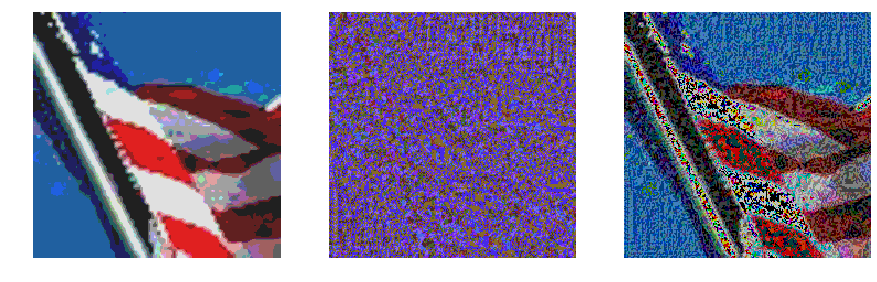

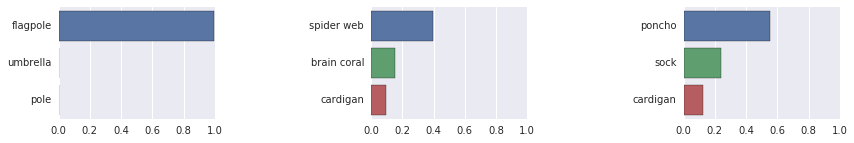

In [286]:
#Show the examples of images as they are distorted
fig, ax = sns.plt.subplots(1,3,figsize=(15,6))
sns.plt.axis("off")
ax[0].imshow(im0.astype('uint8')) 
ax[1].imshow(im1.astype('uint8'))
ax[2].imshow(im2.astype('uint8'))
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
sns.plt.savefig("flagpole_4.png")
sns.plt.show()

fig, ax2 = sns.plt.subplots(1,3,figsize=(14,2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax2[0].set_xlim([0, 1])
ax2[1].set_xlim([0, 1])
ax2[2].set_xlim([0, 1])
sns.barplot(probs_3_1, classes_3_1,orient = "h", ax = ax2[0])
sns.barplot(probs_3_2, classes_3_2,orient = "h", ax = ax2[1])
sns.barplot(probs_3_3, classes_3_3,orient = "h", ax = ax2[2])
sns.plt.savefig("flagpole_4_probs.eps")
sns.plt.show()

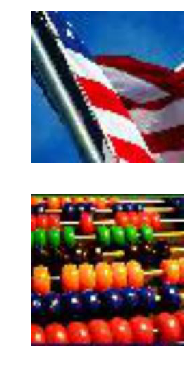

In [6]:
#Show some examples of the images in the dataset

imall = np.zeros((2,3,224,224))
pts = 256
imall[1]=data['X_val'][158]
imall[2]=data['X_val'][356]
imall = (imall//(256/pts))*(256/pts) + 0.5*(256/pts)
imall = imall.transpose(0,2,3,1)
fig, ax = sns.plt.subplots(2,1,figsize=(3,6))
sns.plt.axis("off")
ax[0].imshow(imall[0].astype('uint8')) 
ax[1].imshow(imall[1].astype('uint8'))

    
ax[0].grid(False)
ax[1].grid(False)

ax[0].axis("off")
ax[1].axis("off")

name = 'examples' + str(pts) + '.png'
sns.plt.savefig(name,bbox_inches='tight')
sns.plt.show()